# Własne środowisko

### Autorzy:
Diana Misiaczyńska, Emilia Myrta

### simple_maze.py

Na początek dodajemy potrzebne importy.

In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pygame
import os

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


## Środowisko
Środowisko reprezentuje labirynt w formie siatki o wymiarach 20 × 20.
Agent porusza się po labiryncie, zbierając jabłka do koszyka (nagrody), unikając cytryn (kary) i dąży do dotarcia do koszyka z jabłkami (meta).

---

`__init__` – inicjalizacja środowiska, określenie stanu początkowego, konfiguracja przestrzeni akcji i obserwacji

---

`_generate_maze` – tworzenie układu labiryntu, resetowanie planszy, ustawienie mety, dodanie przeszkód, nagród i kar

---

`reset` – resetowanie środowiska, ponowne wygenerowanie labiryntu i ustawienie agenta na pozycji początkowej

---

`step` – obsługa jednej akcji agenta:

- obliczenie nowej pozycji na podstawie akcji
- jeśli nowa pozycja to ściana – agent się nie porusza
- sprawdzenie typu pola, na które wchodzi agent:
  - jabłko (nagroda): +30 punktów, jabłko znika z planszy
  - cytryna (kara): -2 punkty
  - koszyk (meta): +20 punktów i zakończenie gry
  - zwykłe pole: -0.2 punktu (koszt ruchu)

---

`render` – wizualizowanie labiryntu i agenta za pomocą PyGame

---

`close` – zamykanie okna PyGame

---

##  Legenda pól siatki

| Symbol | Znaczenie       | Efekt w grze              |
|--------|------------------|---------------------------|
| `0`    | Puste pole       | -0.2 pkt (koszt ruchu)    |
| `1`    | Ściana           | Brak ruchu                |
| `2`    |  Jabłko         | +30 pkt, znika po zebraniu|
| `3`    |  Cytryna        | -2 pkt                    |
| `9`    |  Koszyk (meta)  | +20 pkt, kończy grę       |

In [7]:
class SimpleMazeEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(self, render_mode=None):
        super().__init__()
        self.grid_size = (20, 20)
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=max(self.grid_size)-1, shape=(2,), dtype=np.int32)
        self.grid = np.zeros(self.grid_size, dtype=int)
        self._generate_maze()
        self.agent_pos = [0, 0]
        self.render_mode = render_mode
        self.window = None
        self.clock = None

        tile_size = 25
        self.tile_size = tile_size

        base_path = os.path.join("gymnasium_env", "envs", "img")
        self.images = {
            2: pygame.transform.scale(pygame.image.load(os.path.join(base_path, "reward.png")), (tile_size, tile_size)),
            3: pygame.transform.scale(pygame.image.load(os.path.join(base_path, "penalty.png")),
                                      (tile_size, tile_size)),
            9: pygame.transform.scale(pygame.image.load(os.path.join(base_path, "meta.png")), (tile_size, tile_size)),
            "agent": pygame.transform.scale(pygame.image.load(os.path.join(base_path, "agent.png")),
                                            (tile_size, tile_size)),
        }

    def _generate_maze(self):
        self.grid[:] = 0
        self.grid[19, 19] = 9

        walls = (
                [(i, 3) for i in range(1, 10)] +
                [(9, j) for j in range(3, 12)] +
                [(i, 11) for i in range(10, 18)] +
                [(17, j) for j in range(6, 16)] +
                [(i, 6) for i in range(5, 17)] +
                [(5, j) for j in range(6, 10)] +
                [(13, j) for j in range(0, 5)] +
                [(j, 15) for j in range(3, 10)] +
                [(11, 13), (11, 14), (12, 14), (13, 14)]
        )

        for x, y in walls:
            self.grid[x, y] = 1

        for x, y in [(1, 1), (7, 17), (14, 2), (18, 18)]:
            self.grid[x, y] = 2

        for x, y in [(3, 7), (11, 5), (16, 12), (5, 17)]:
            self.grid[x, y] = 3

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._generate_maze()
        self.agent_pos = [0, 0]
        return np.array(self.agent_pos), {}

    def step(self, action):
        x, y = self.agent_pos
        if action == 0: y = max(0, y - 1)
        elif action == 1: y = min(self.grid_size[1] - 1, y + 1)
        elif action == 2: x = max(0, x - 1)
        elif action == 3: x = min(self.grid_size[0] - 1, x + 1)
        if self.grid[x, y] == 1: x, y = self.agent_pos
        self.agent_pos = [x, y]

        tile = self.grid[x, y]
        reward, done = -0.2, False
        if tile == 2:
            reward = 20
            self.grid[x, y] = 0
        elif tile == 3:
            reward = -2
        elif tile == 9:
            reward = 20
            done = True

        return np.array(self.agent_pos), reward, done, False, {}

    def render(self):
        if self.window is None:
            self.window = pygame.display.set_mode(
                (self.grid_size[1] * self.tile_size, self.grid_size[0] * self.tile_size))
            pygame.display.set_caption("Maze Agent")

        if self.clock is None:
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.grid_size[1] * self.tile_size, self.grid_size[0] * self.tile_size))
        canvas.fill((255, 255, 255))

        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                tile_type = self.grid[i, j]
                if tile_type in self.images:
                    canvas.blit(self.images[tile_type], (j * self.tile_size, i * self.tile_size))
                elif tile_type == 1:
                    pygame.draw.rect(canvas, (0, 0, 0),
                                     pygame.Rect(j * self.tile_size, i * self.tile_size, self.tile_size,
                                                 self.tile_size))

        ax, ay = self.agent_pos
        canvas.blit(self.images["agent"], (ay * self.tile_size, ax * self.tile_size))

        self.window.blit(canvas, (0, 0))
        pygame.display.update()
        self.clock.tick(5)

    def close(self):
        if self.window:
            pygame.quit()


### main.py

In [3]:
import gymnasium as gym
import gymnasium_env
import numpy as np
import matplotlib.pyplot as plt

## Trenowanie agenta
Agent jest trenowany z następującymi parametrami:

In [14]:
EPISODES = 1000
ALPHA = 0.1
GAMMA = 0.99
EPSILON = 1.0
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.01
MAX_STEPS = 500

Tworzymy środowisko ```SimpleMaze-v0``` i inicjalizujemy Q-tabelę jako trójwymiarową macierz:
* (x, y, action) – każda pozycja ma ocenę dla 4 możliwych akcji.
---
Q-learning to metoda uczenia ze wzmocnieniem, w której agent uczy się podejmować decyzje w środowisku, maksymalizując sumę nagród w czasie. Agent nie potrzebuje znajomości zasad działania środowiska – uczy się przez doświadczenie.

In [15]:
env = gym.make("SimpleMaze-v0")

grid_shape = env.unwrapped.grid_size
q_table = np.zeros((grid_shape[0], grid_shape[1], env.action_space.n))

Agent jest trenowany przez 500 episodów. W każdym epizodzie następuje:

1. Reset środowiska - agent zaczyna od pozycji początkowej.

2. Agent wykonuje ruchy (max 500 kroków):
   - Z pewnym prawdopodobieństwem (`epsilon`) wybiera losowy ruch – na początku często, później coraz rzadziej.
   - W przeciwnym razie wybiera najlepszy znany ruch według Q-tabeli.

3. Agent wykonuje akcję w środowisku i otrzymuje:
   - nową pozycję,
   - nagrodę (np. +30 za jabłko, -2 za cytrynę),
   - informację, czy dotarł do mety.

4. Kara za kręcenie się w kółko- jeśli agent zbyt często wraca w to samo miejsce (więcej niż 4 razy w ostatnich 10 krokach), dostaje dodatkową karę (-3 punkty).

5. Aktualizacja Q-tabeli.

6. Zmniejszanie eksploracji (`epsilon`)
   Po każdym epizodzie wartość `epsilon` jest zmniejszana, aby agent coraz częściej wykorzystywał wyuczoną strategię zamiast zgadywać. \
\
Co 50 epizodów wyświetla się suma nagród i aktualna wartość `epsilon`.

---

In [16]:
rewards_per_episode = []

for episode in range(EPISODES):
    steps = 0
    state, _ = env.reset()
    # if (episode + 1) % 50 == 0:
    #     print(">>> Grid przed treningiem:")
    #     print(env.unwrapped.grid)

    done = False
    total_reward = 0
    recent_positions = []

    while not done and steps < MAX_STEPS:
        x, y = state

        if np.random.random() < EPSILON:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[x, y])

        next_state, reward, done, _, _ = env.step(action)

        recent_positions.append(tuple(next_state))
        if len(recent_positions) > 10:
            recent_positions.pop(0)
        if recent_positions.count(tuple(next_state)) > 4:
            reward -= 3

        nx, ny = next_state
        old_value = q_table[x, y, action]
        next_max = np.max(q_table[nx, ny])
        new_value = old_value + ALPHA * (reward + GAMMA * next_max - old_value)
        q_table[x, y, action] = new_value

        state = next_state
        total_reward += reward
        steps += 1

    EPSILON = max(EPSILON_MIN, EPSILON * EPSILON_DECAY)
    rewards_per_episode.append(total_reward)

    if (episode + 1) % 50 == 0:
        print(f"Epizod {episode + 1}, suma nagród: {total_reward:.2f}, epsilon: {EPSILON:.3f}")


Epizod 50, suma nagród: -217.80, epsilon: 0.778
Epizod 100, suma nagród: -157.80, epsilon: 0.606
Epizod 150, suma nagród: -175.80, epsilon: 0.471
Epizod 200, suma nagród: -90.80, epsilon: 0.367
Epizod 250, suma nagród: 13.20, epsilon: 0.286
Epizod 300, suma nagród: -114.60, epsilon: 0.222
Epizod 350, suma nagród: 25.20, epsilon: 0.173
Epizod 400, suma nagród: -78.60, epsilon: 0.135
Epizod 450, suma nagród: -94.60, epsilon: 0.105
Epizod 500, suma nagród: 44.60, epsilon: 0.082
Epizod 550, suma nagród: 57.60, epsilon: 0.063
Epizod 600, suma nagród: 24.60, epsilon: 0.049
Epizod 650, suma nagród: 66.40, epsilon: 0.038
Epizod 700, suma nagród: 51.80, epsilon: 0.030
Epizod 750, suma nagród: 33.80, epsilon: 0.023
Epizod 800, suma nagród: 72.00, epsilon: 0.018
Epizod 850, suma nagród: 52.60, epsilon: 0.014
Epizod 900, suma nagród: 52.20, epsilon: 0.011
Epizod 950, suma nagród: 52.60, epsilon: 0.010
Epizod 1000, suma nagród: 52.60, epsilon: 0.010


## Wyniki
Tworzymy dwa wykresy, które pokazują, jak zmieniały się nagrody zdobywane przez agenta w trakcie treningu.

1. Lewy wykres pokazuje nagrodę w każdym episodzie
2. Prawy wykres pokazuje wygładzoną średnią nagród (średnia krocząca z 50 epizodów), dzięki czemu łatwiej zauważyć ogólny trend.

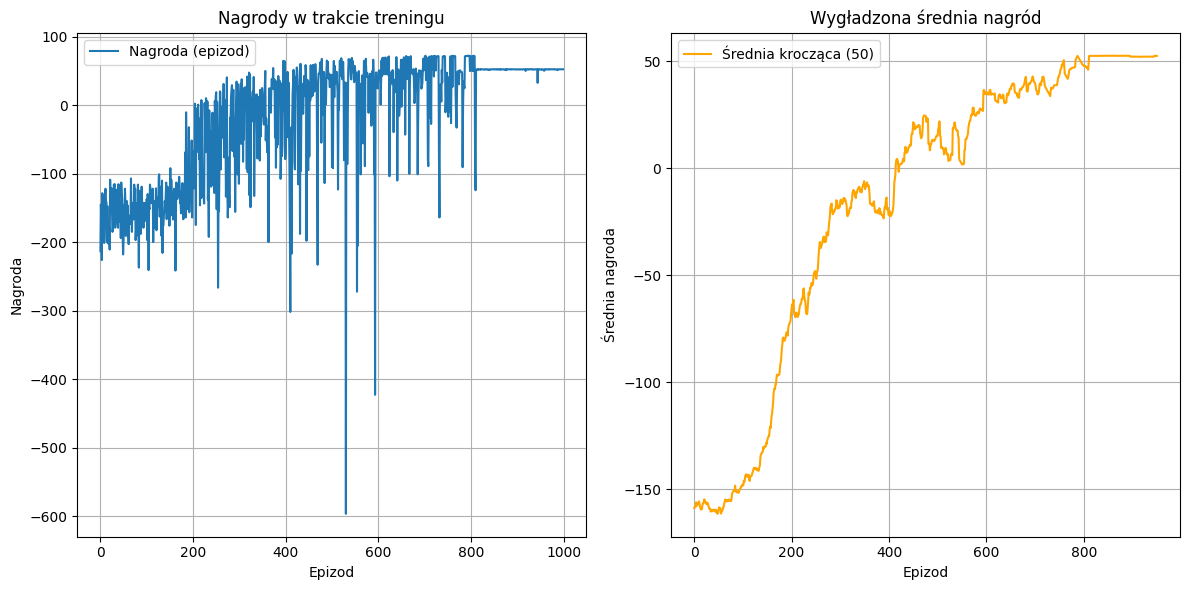

In [22]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')


rolling_mean = moving_average(rewards_per_episode, 50)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(rewards_per_episode, label='Nagroda (epizod)')
plt.title("Nagrody w trakcie treningu")
plt.xlabel("Epizod")
plt.ylabel("Nagroda")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rolling_mean, label='Średnia krocząca (50)', color='orange')
plt.title("Wygładzona średnia nagród")
plt.xlabel("Epizod")
plt.ylabel("Średnia nagroda")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()




![labirynt](lab1.png)
![labirynt](labirynt.png)
![labirynt](lab3.png)
![labirynt](lab4.png)


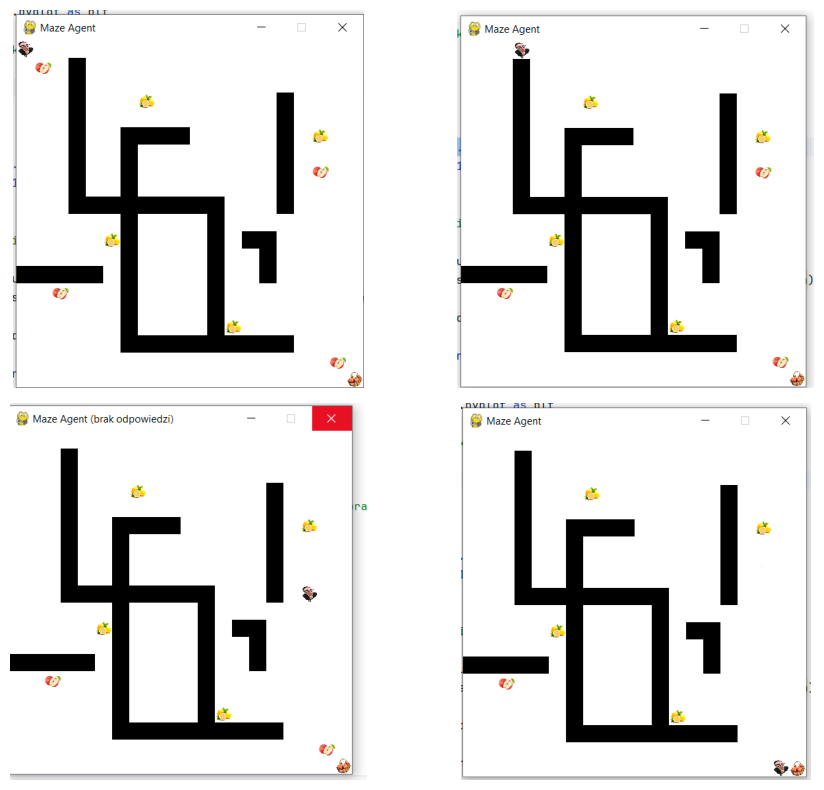

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

filenames = ["lab1.png", "labirynt.png", "lab3.png", "lab4.png"]

plt.figure(figsize=(10, 8))

for i, fname in enumerate(filenames):
    img = mpimg.imread(fname)
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()